# DES 3x2pt

The key project from the Dark Energy Survey Year 1 phase was the 3x2pt analysis -- the simultaneous fit to three different two point functions. This notebook takes the cosmological parameters and returns sets of training samples using the `SampleGenerator` tool. These training samples could then be used to build an emulator that spans the space of the DES Y1 3x2pt posterior.

In [1]:
import numpy as np
import sample_generator as sg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Formatting
plt.rc("font", size=18, family="serif")
plt.rc("text", usetex=True)

In [3]:
#chain = np.load("des_y1_LCDM_cosmo_pars_only.npy")
chain = np.loadtxt("DES_posterior.txt").T
#Convert A_s to ln(10^{10}A_s)
chain[:,4] = np.log(1e10*chain[:,4])
print(chain.shape)
print("Parameters are: Omega_m, h0, Omega_b, n_s, ln(10^{10}A_s), Omega_\nu*h^2, N_eff, w0")
labels = [r"$\Omega_m$", r"$h$", r"$\Omega_b$", r"$n_s$", r"$\ln(10^{10}A_s)$", r"$\Omega_\nu h^2$", r"$N_{\rm eff}$", r"$w_0$"]

(3063, 8)
Parameters are: Omega_m, h0, Omega_b, n_s, ln(10^{10}A_s), Omega_
u*h^2, N_eff, w0


In [4]:
#Make a function to get back a fig, axes pair with the correct spacing,
#axes removed, and other formatting
def get_figax(N, labels=None, projected=False):
    """N is the length along the diagonal of the 2d axes array"""
    fig, axes = plt.subplots(ncols=N-1, nrows=N-1, figsize=(9,9))
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(0, N-2):
        for j in range(i+1, N-1):
            fig.delaxes(axes[i][j])
    for i in range(0, N-1):
        for j in range(0, i+1):
            if projected:
                axes[i][j].set_xlim(-0.5, 0.5)
                axes[i][j].set_ylim(-0.5, 0.5)

            if i < N-2:
                axes[i][j].set_xticks([])
                axes[i][j].set_xticklabels([])
            if j > 0:
                axes[i][j].set_yticks([])
                axes[i][j].set_yticklabels([])
            if labels is not None:
                if j == 0:
                    axes[i][j].set_ylabel(labels[i+1])
                if i == N-2:
                    axes[i][j].set_xlabel(labels[j])
    return fig, axes

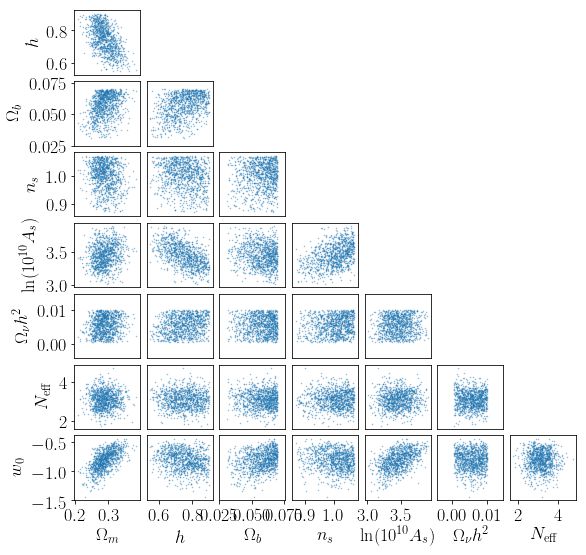

In [5]:
#Make a scatter plot of the tail of the chain
tail = chain[-1000:].T
Np = len(chain[0])
fig, ax = get_figax(Np, labels)
for i in range(0, Np-1):
    for j in range(0, i+1):
        ax[i][j].scatter(tail[j], tail[i+1], marker='.', s=1, alpha=0.5)

In [6]:
#Create a Sample Generator object
Generator = sg.SampleGenerator(chain=tail, scale=5)
Generator.set_seed(123456)

In [7]:
#Generate samples
Nsamples = 250
x = Generator.get_samples(Nsamples, "LH")

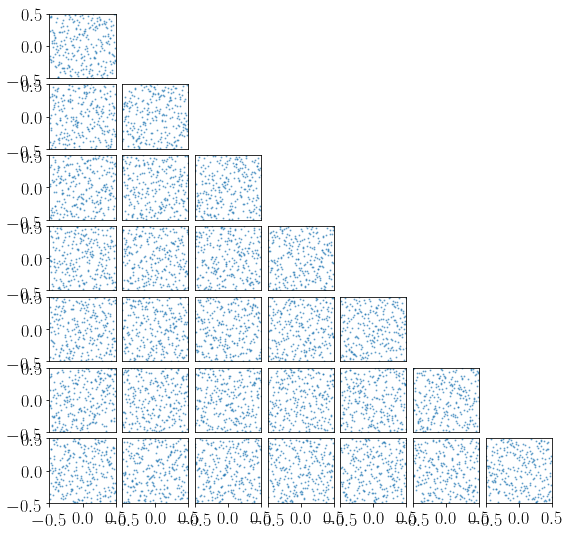

In [8]:
#Make a scatter plot of the projected points
Np = len(chain[0])
fig, ax = get_figax(Np, labels=None, projected=True)
proj = Generator.current_projected_samples

for i in range(0, Np-1):
    for j in range(0, i+1):
        parj = Generator.current_projected_samples[:,j]
        pari = Generator.current_projected_samples[:,i+1]
        ax[i][j].scatter(parj, pari, marker='o', s=1, alpha=0.5)
plt.savefig("projected_samples.png", dpi=300, bbox_inches="tight")

In [9]:
#Cut along any DES priors
cut = x[:,1] < 0.9
x = x[cut]
cut = (x[:,5] > 0)*(x[:,5] < 0.01) #cut on Omega_nuh^2
x = x[cut]
cut = x[:,3] < 1.07 #cut on n_s
x = x[cut]
cut = x[:,2] < 0.07 #cut on Omega_b
x = x[cut]
print x.shape

(122, 8)


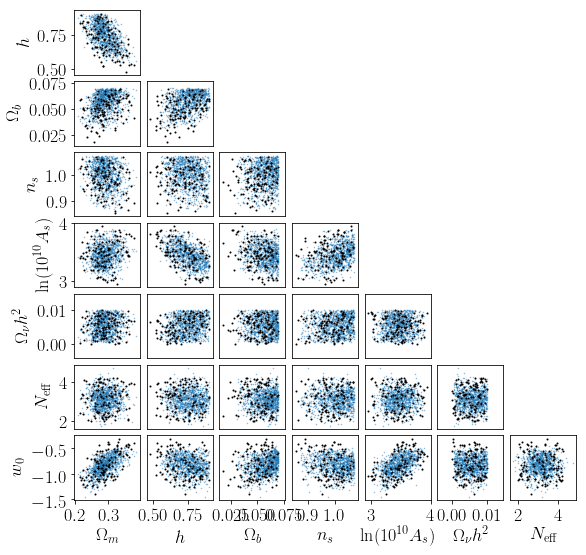

In [10]:
#Make a scatter plot of the tail again but with the generated points overlaid
#Make a scatter plot of the tail of the chain
fig, ax = get_figax(Np, labels)
for i in range(0, Np-1):
    for j in range(0, i+1):
        ax[i][j].scatter(tail[j], tail[i+1], marker='.', s=1, alpha=0.5)
        ax[i][j].scatter(x[:,j], x[:,i+1], marker='.', s=4, c='k')

In [11]:
np.savetxt("DES_training_points.txt", x, fmt="%e", header="Omega_m h0 Omega_b n_s ln(10^{10}A_s) Omeganuh2 Neff w")
fig.savefig("LCDM_design_example.png", dpi=300, bbox_inches="tight")